In [1]:

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Train timetable ILP (single-direction, single-track per station) with Gurobi.

Model summary (variables in minutes):

Sets
-----
S: ordered stations (s_0,...,s_L) from origin to terminal.
I: trains.
E: consecutive station pairs (s_k, s_{k+1}).

Parameters (from Excel)
-----------------------
- T: time horizon upper bound [0, T].
- H: minimum headway at any station (minutes).
- MINSTOP, MAXSTOP: dwell time bounds for intermediate stations (minutes).
- speed[i]: speed grade for each train i.
- stop[i, s] ∈ {0,1}: whether train i stops at station s (1=stop).
- tau[e, v]: running time on section e for speed v (minutes).

Decision variables
------------------
- arr[i, s] ≥ 0: arrival time of train i at station s.
- dep[i, s] ≥ 0: departure time of train i at station s.
- y[i, k] ∈ {0,1} for i < k: global precedence of trains (1 if i runs ahead of k over the whole line).

Objective
---------
minimize  ∑_{i∈I} ( arr[i, s_L] - dep[i, s_0] )   # total travel time

Constraints
-----------
(1) Time bounds: 0 ≤ arr[i,s], dep[i,s] ≤ T.
(2) Section running times:  arr[i, s_{k+1}] = dep[i, s_k] + tau[(s_k,s_{k+1}), speed[i]]
(3) Dwell/pass-through at intermediate stations s ∈ S\{s_0, s_L}:
    - If stop[i,s]=1:   MINSTOP ≤ dep[i,s] - arr[i,s] ≤ MAXSTOP
    - If stop[i,s]=0:   dep[i,s] = arr[i,s]
(4) End stations:
    - Origin s_0:  arr[i,s_0] = dep[i,s_0]
    - Terminal s_L: arr[i,s_L] = dep[i,s_L]
(5) Station capacity + headway with no-overtaking:
    For each station s and each unordered pair {i,k}, with i<k, let M = T + H.
      dep[i,s] + H ≤ arr[k,s] + M * (1 - y[i,k])
      dep[k,s] + H ≤ arr[i,s] + M * y[i,k]
    This enforces that either i clears station s at least H minutes before k arrives (if y[i,k]=1),
    or vice versa (if y[i,k]=0) — consistent across all stations due to the global y[i,k].
"""

import sys, os, pandas as pd
from itertools import tee
import gurobipy as gp
from gurobipy import GRB

def consecutive_pairs(iterable):
    "Yield consecutive pairs (s_k, s_{k+1})"
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def read_instance(xlsx_path: str):
    xls = pd.ExcelFile(xlsx_path)

    stations = pd.read_excel(xls, sheet_name="station")
    assert {'station','mile'}.issubset(stations.columns), "station sheet must have columns: station, mile"
    stations = stations.sort_values('mile').reset_index(drop=True)
    S = stations['station'].tolist()
    s0, sL = S[0], S[-1]
    E = [f"{a}-{b}" for a,b in consecutive_pairs(S)]

    trains = pd.read_excel(xls, sheet_name="train")
    # required columns: trainNO, speed, plus one column per station (0/1 stop flags)
    assert {'trainNO','speed'}.issubset(trains.columns), "train sheet must have columns: trainNO, speed, and station stop flags"
    # Ensure stop columns match station names
    for s in S:
        if s not in trains.columns:
            raise ValueError(f"train sheet missing stop column for station '{s}'")
    I = trains['trainNO'].tolist()
    speed = dict(zip(trains['trainNO'], trains['speed']))
    stop = {(row['trainNO'], s): int(row[s]) for _, row in trains.iterrows() for s in S}

    runtime = pd.read_excel(xls, sheet_name="runtime")
    # First col 'station' contains strings like 'A-B'; other columns are speed grades (ints)
    rt = {}
    # identify available speed grade columns from header (excluding the first)
    speed_cols = [c for c in runtime.columns if c != 'station']
    # Validate that the sections match E
    if set(runtime['station'].tolist()) != set(E):
        missing = set(E) - set(runtime['station'].tolist())
        extra = set(runtime['station'].tolist()) - set(E)
        raise ValueError(f"runtime sheet sections mismatch. Missing: {missing}, Extra: {extra}")
    for _, row in runtime.iterrows():
        sec = row['station']
        rt[sec] = {}
        for sc in speed_cols:
            rt[sec][int(sc)] = float(row[sc])

    params = pd.read_excel(xls, sheet_name="parameter")
    # Interpret the slightly unusual layout: first column header 'T' holds the horizon as its *column name*,
    # and the second column holds numeric values for H, MINSTOP, MAXSTOP. Example:
    #         T  160
    # 0        H    5
    # 1  MINSTOP    2
    # 2  MAXSTOP   15
    colnames = list(params.columns)
    try:
        T = float(colnames[1])
    except Exception as e:
        raise ValueError("Parameter sheet: expected the second column *header* to be the numeric T (time horizon).") from e
    # Remaining rows map name -> value from column 1
    param_map = dict(zip(params[colnames[0]].astype(str), params[colnames[1]]))
    H = float(param_map.get('H'))
    MINSTOP = float(param_map.get('MINSTOP'))
    MAXSTOP = float(param_map.get('MAXSTOP'))
    if any(v is None for v in [H, MINSTOP, MAXSTOP]):
        raise ValueError("Missing H, MINSTOP, or MAXSTOP in parameter sheet.")

    return dict(S=S, s0=s0, sL=sL, E=E, I=I, speed=speed, stop=stop, runtime=rt,
                speed_cols=list(map(int, speed_cols)), T=T, H=H, MINSTOP=MINSTOP, MAXSTOP=MAXSTOP)

def build_and_solve(xlsx_path: str, time_limit: float = None, mip_gap: float = None, log_to_console: bool = True):
    data = read_instance(xlsx_path)
    S, s0, sL, E, I = data['S'], data['s0'], data['sL'], data['E'], data['I']
    speed, stop, runtime = data['speed'], data['stop'], data['runtime']
    T, H, MINSTOP, MAXSTOP = data['T'], data['H'], data['MINSTOP'], data['MAXSTOP']

    model = gp.Model("train_timetable")
    if not log_to_console:
        model.Params.OutputFlag = 0
    if time_limit is not None:
        model.Params.TimeLimit = time_limit
    if mip_gap is not None:
        model.Params.MIPGap = mip_gap

    # Big-M for precedence
    M = T + H

    # Decision variables
    arr = model.addVars(I, S, name="arr", lb=0.0, ub=T)
    dep = model.addVars(I, S, name="dep", lb=0.0, ub=T)
    y = model.addVars([(i,k) for idx,i in enumerate(I) for k in I[idx+1:]], vtype=GRB.BINARY, name="y")

    # Section running-time equalities
    for i in I:
        v = int(speed[i])
        for (a,b) in zip(S[:-1], S[1:]):
            sec = f"{a}-{b}"
            tau = runtime[sec][v]
            model.addConstr(arr[i,b] == dep[i,a] + tau, name=f"run_{i}_{a}_{b}")

    # End stations equalities
    for i in I:
        model.addConstr(arr[i,s0] == dep[i,s0], name=f"origin_{i}")
        model.addConstr(arr[i,sL] == dep[i,sL], name=f"terminal_{i}")

    # Dwell / pass-through at intermediate stations
    for i in I:
        for s in S[1:-1]:
            if int(stop[(i,s)]) == 1:
                model.addConstr(dep[i,s] - arr[i,s] >= MINSTOP, name=f"dwell_min_{i}_{s}")
                model.addConstr(dep[i,s] - arr[i,s] <= MAXSTOP, name=f"dwell_max_{i}_{s}")
            else:
                model.addConstr(dep[i,s] == arr[i,s], name=f"pass_{i}_{s}")

    # Station capacity and global precedence (no overtaking)
    for idx,i in enumerate(I):
        for k in I[idx+1:]:
            for s in S:
                model.addConstr(dep[i,s] + H <= arr[k,s] + M*(1 - y[i,k]), name=f"hdwy1_{i}_{k}_{s}")
                model.addConstr(dep[k,s] + H <= arr[i,s] + M*(    y[i,k]), name=f"hdwy2_{i}_{k}_{s}")

    # Objective: minimize total travel time
    model.setObjective(gp.quicksum(arr[i,S[-1]] - dep[i,S[0]] for i in I), GRB.MINIMIZE)

    model.update()
    model.optimize()

    # Collect solution (if optimal or feasible)
    status = model.Status
    result = {
        "status": status,
        "status_string": model.Status,
        "objective": None,
        "gap": None,
        "arrivals": None,
        "departures": None,
    }
    if status in (GRB.OPTIMAL, GRB.SUBOPTIMAL, GRB.TIME_LIMIT, GRB.INTERRUPTED):
        try:
            obj = model.ObjVal
        except Exception:
            obj = None
        result["objective"] = obj
        try:
            gap = model.MIPGap
        except Exception:
            gap = None
        result["gap"] = gap

        # Build tables
        arr_tbl = []
        dep_tbl = []
        for i in I:
            for s in S:
                arr_tbl.append({"train": i, "station": s, "arr": arr[i,s].X})
                dep_tbl.append({"train": i, "station": s, "dep": dep[i,s].X})
        result["arrivals"] = pd.DataFrame(arr_tbl).pivot(index="train", columns="station", values="arr").reset_index()
        result["departures"] = pd.DataFrame(dep_tbl).pivot(index="train", columns="station", values="dep").reset_index()
        # Travel times
        result["travel_time"] = pd.DataFrame({
            "train": I,
            "travel_time": [result["arrivals"].set_index("train").loc[i, S[-1]] - result["departures"].set_index("train").loc[i, S[0]] for i in I]
        })

    return model, result, data

def main():
    import argparse
    parser = argparse.ArgumentParser(description="Gurobi ILP for single-direction train timetable")
    parser.add_argument("--xlsx", type=str, default="常规图.xlsx", help="Path to Excel input")
    parser.add_argument("--time_limit", type=float, default=None, help="Time limit in seconds")
    parser.add_argument("--mip_gap", type=float, default=None, help="Relative MIP gap target, e.g., 0.01")
    parser.add_argument("--no_log", action="store_true", help="Disable solver log to console")
    parser.add_argument("--out_prefix", type=str, default="timetable_solution", help="Prefix for CSV outputs")
    args = parser.parse_args()

    model, result, data = build_and_solve(args.xlsx, args.time_limit, args.mip_gap, (not args.no_log))

    # Save results if available
    if result["arrivals"] is not None:
        result["arrivals"].to_csv(f"{args.out_prefix}_arrivals.csv", index=False, encoding="utf-8-sig")
        result["departures"].to_csv(f"{args.out_prefix}_departures.csv", index=False, encoding="utf-8-sig")
        result["travel_time"].to_csv(f"{args.out_prefix}_travel_time.csv", index=False, encoding="utf-8-sig")
        print(f"Objective (total travel time):", result["objective"])
        if result["gap"] is not None:
            print(f"MIPGap:", result["gap"])
        print(f"Saved CSVs with prefix '{args.out_prefix}_*.csv'")
    else:
        print("No feasible/optimal solution to save. Solver status:", result["status"])

if __name__ == "__main__":
    main()


usage: ipykernel_launcher.py [-h] [--xlsx XLSX] [--time_limit TIME_LIMIT]
                             [--mip_gap MIP_GAP] [--no_log]
                             [--out_prefix OUT_PREFIX]
ipykernel_launcher.py: error: unrecognized arguments: --f=/Users/luhongliang/Library/Jupyter/runtime/kernel-v3419df5860532cfeefe62d27be7a4601835f45158.json


SystemExit: 2

/Users/luhongliang/opt/anaconda3/envs/ORLM/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
import gurobipy as gp
from gurobipy import GRB

# Create model
model = gp.Model("max_flow_network")

# Define the network capacities (from_node, to_node): capacity
capacities = {
    # From Node 0
    (0, 1): 3, (0, 2): 7, (0, 3): 2, (0, 4): 18, (0, 5): 18, (0, 6): 14, (0, 7): 10,
    # From Node 1
    (1, 0): 1, (1, 2): 10, (1, 3): 16, (1, 4): 14, (1, 6): 6, (1, 7): 10,
    # From Node 2
    (2, 0): 4, (2, 3): 7, (2, 4): 2, (2, 5): 2, (2, 6): 6, (2, 7): 10,
    # From Node 3
    (3, 0): 2, (3, 1): 3, (3, 2): 7, (3, 4): 20, (3, 5): 8, (3, 6): 6, (3, 7): 10,
    # From Node 4
    (4, 0): 1, (4, 1): 20, (4, 2): 4, (4, 3): 8, (4, 5): 13, (4, 6): 8, (4, 7): 1,
    # From Node 5
    (5, 0): 16, (5, 1): 9, (5, 2): 17, (5, 3): 17, (5, 4): 11, (5, 6): 7, (5, 7): 8,
    # From Node 6
    (6, 0): 3, (6, 1): 7, (6, 2): 14, (6, 3): 1, (6, 4): 20, (6, 5): 5, (6, 7): 13,
    # From Node 7 (destination receives only)
    (7, 0): 0, (7, 1): 0, (7, 2): 0, (7, 3): 0, (7, 4): 0, (7, 5): 0, (7, 6): 0
}

# Create flow variables for each edge with capacity > 0
flow_vars = {}
for (i, j), cap in capacities.items():
    if cap > 0:
        flow_vars[(i, j)] = model.addVar(lb=0, ub=cap, vtype=GRB.CONTINUOUS, name=f"f_{i}_{j}")

# Add flow conservation constraints for intermediate nodes (1-6)
for node in range(1, 7):  # Nodes 1 through 6
    inflow = gp.quicksum(flow_vars.get((i, node), 0) for i in range(8) if (i, node) in flow_vars)
    outflow = gp.quicksum(flow_vars.get((node, j), 0) for j in range(8) if (node, j) in flow_vars)
    model.addConstr(inflow == outflow, f"flow_conservation_{node}")

# Objective: maximize flow from source (0) to sink (7)
source_outflow = gp.quicksum(flow_vars.get((0, j), 0) for j in range(8) if (0, j) in flow_vars)
source_inflow = gp.quicksum(flow_vars.get((i, 0), 0) for i in range(8) if (i, 0) in flow_vars)
net_flow = source_outflow - source_inflow
model.setObjective(net_flow, GRB.MAXIMIZE)

# Solve
model.optimize()

# Extract results
if model.Status == GRB.OPTIMAL:
    max_flow = model.ObjVal
    print(f"optimal_value = {max_flow}")
    print(f"objective = {max_flow}")
    print(f"result = {max_flow}")
elif model.Status == GRB.INFEASIBLE:
    print("optimal_value = INFEASIBLE")
    print("objective = INFEASIBLE")
    print("result = INFEASIBLE")
elif model.Status == GRB.UNBOUNDED:
    print("optimal_value = UNBOUNDED")
    print("objective = UNBOUNDED")
    print("result = UNBOUNDED")
else:
    print(f"optimal_value = ERROR (Status: {model.Status})")
    print(f"objective = ERROR (Status: {model.Status})")
    print(f"result = ERROR (Status: {model.Status})")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[rosetta2] - Darwin 24.6.0 24G84)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 6 rows, 47 columns and 74 nonzeros
Model fingerprint: 0xbd7441b6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 20 columns
Presolve time: 0.01s
Presolved: 6 rows, 27 columns, 42 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.2000000e+01   3.600000e+01   0.000000e+00      0s
      10    6.2000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.200000000e+01
optimal_value = 62.0
objective = 62.0
result = 62.0


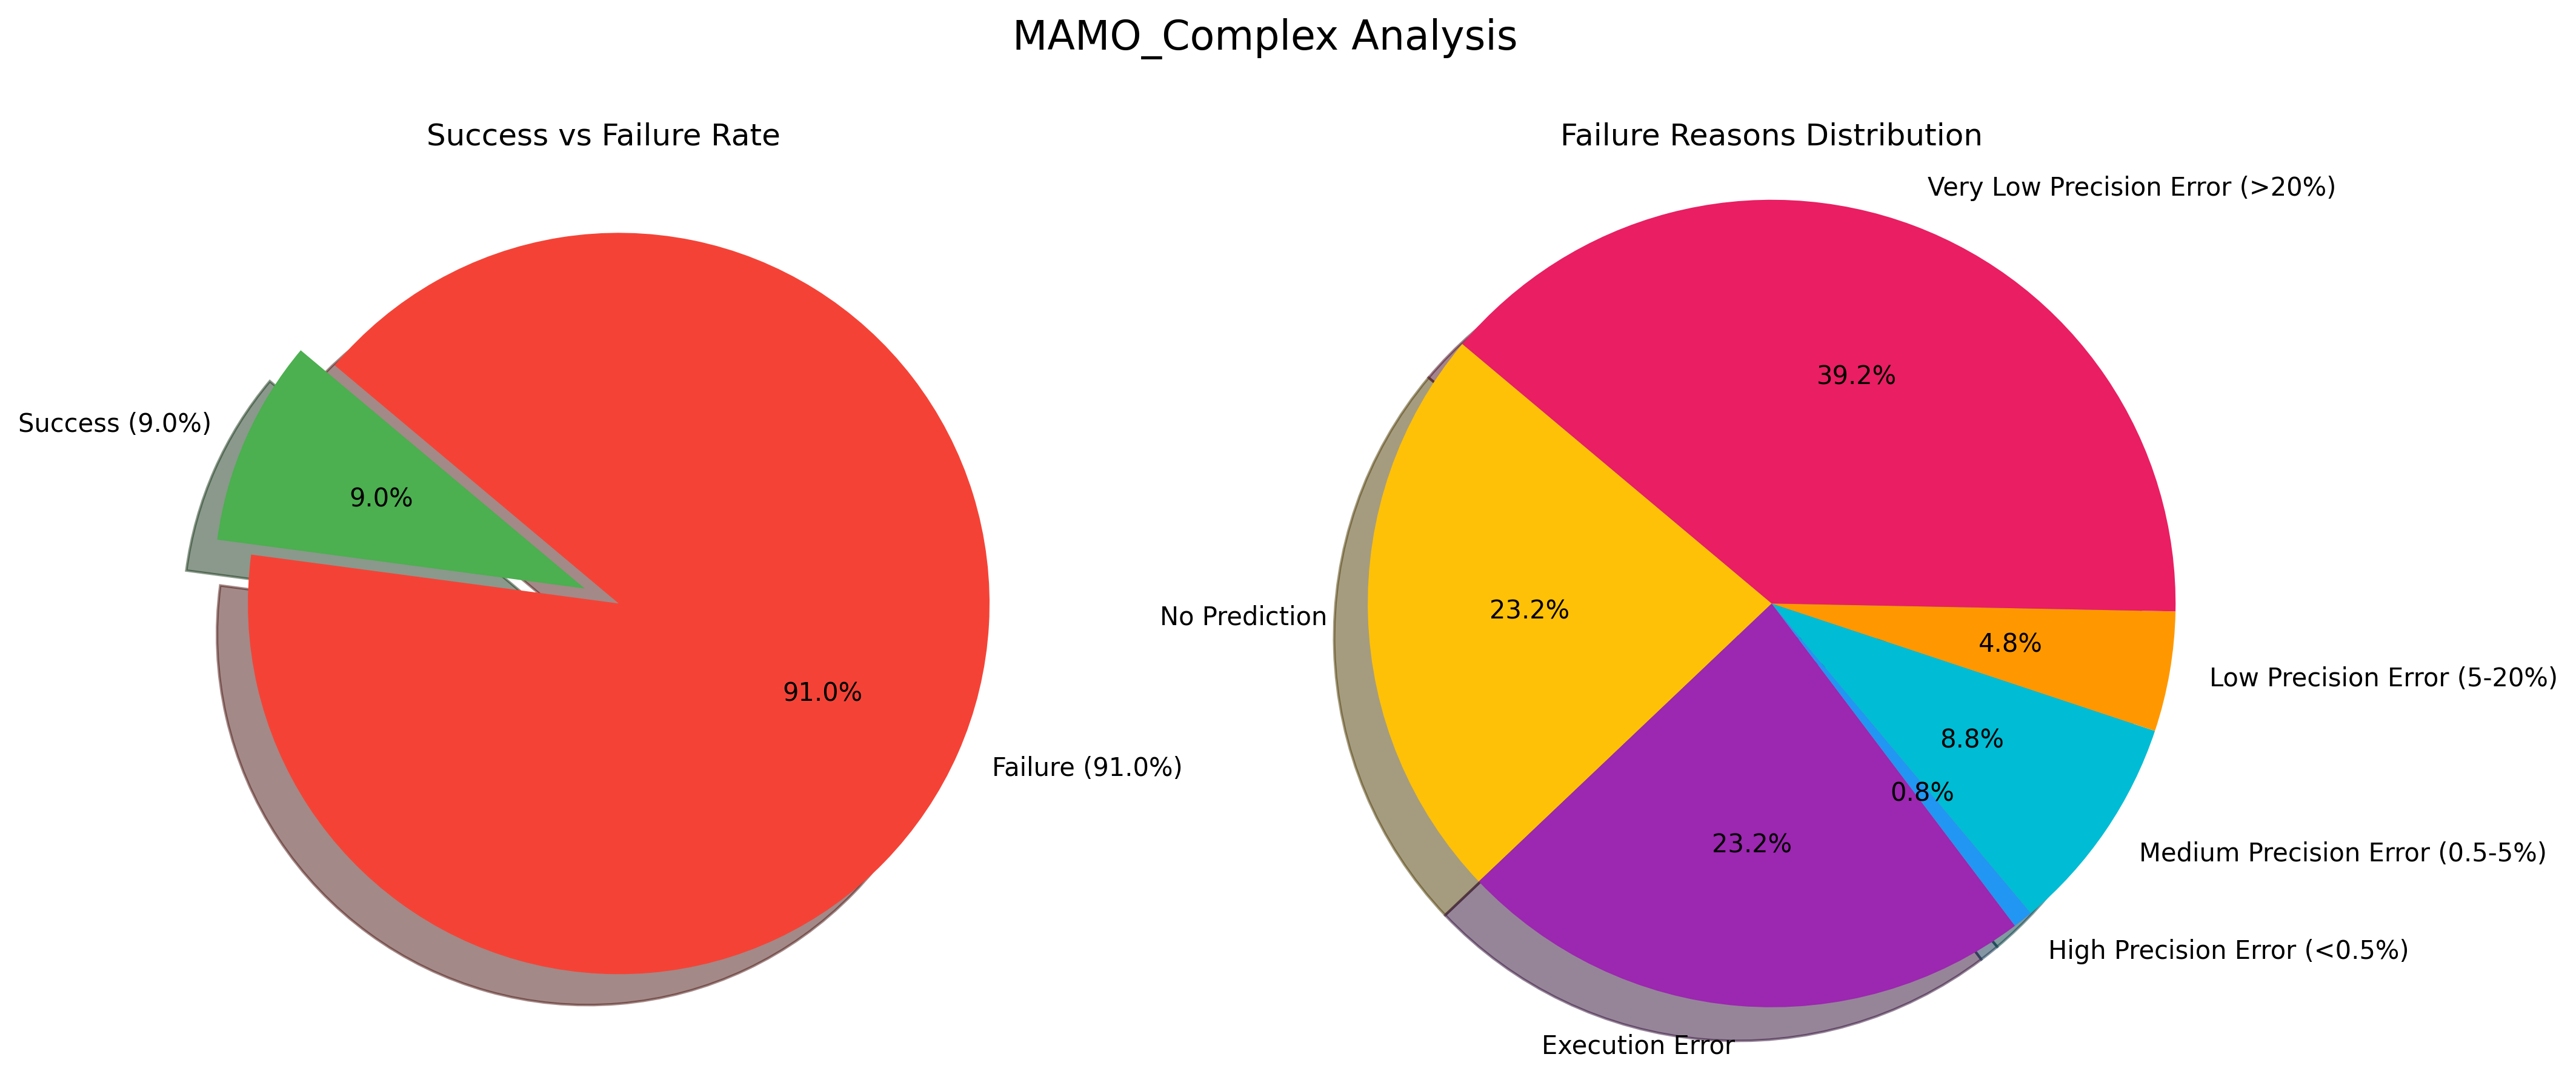

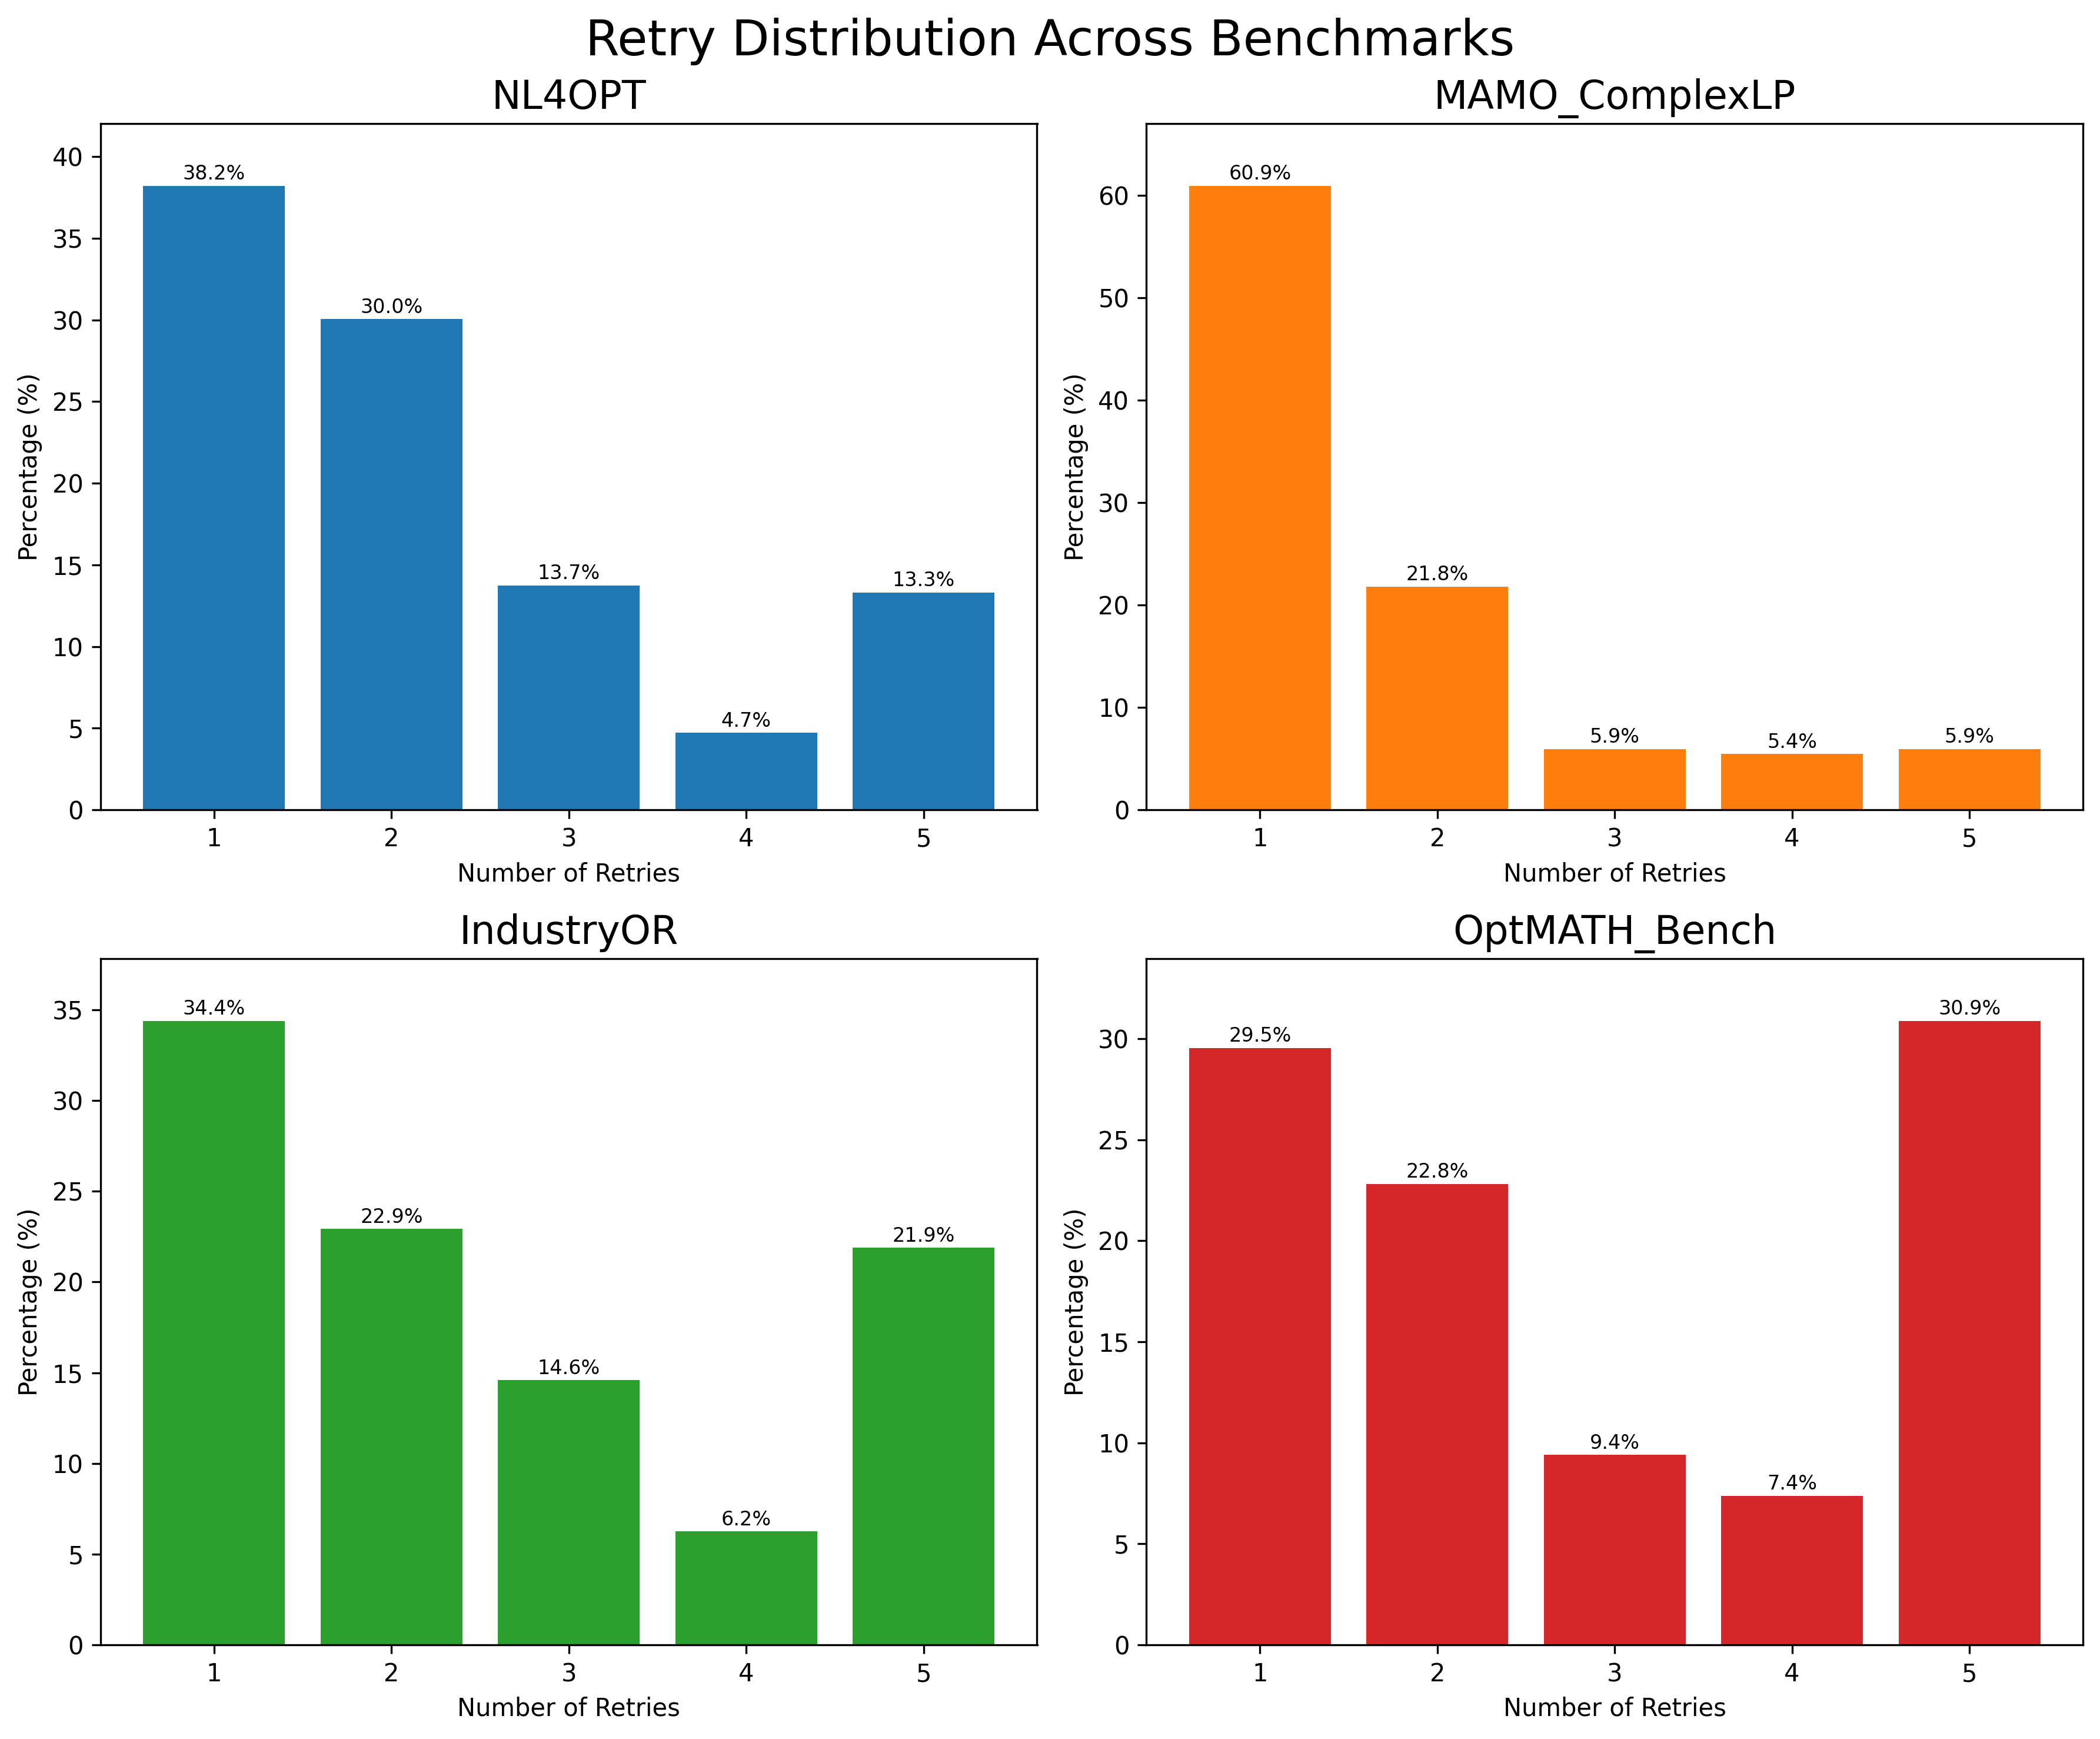

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
data = {
    "NL4OPT": {
        "1_retries": {"count": 89, "percentage": 38.197424892703864},
        "2_retries": {"count": 70, "percentage": 30.042918454935624},
        "3_retries": {"count": 32, "percentage": 13.733905579399142},
        "4_retries": {"count": 11, "percentage": 4.721030042918455},
        "5_retries": {"count": 31, "percentage": 13.304721030042918}
    },
    "MAMO_ComplexLP": {
        "1_retries": {"count": 123, "percentage": 60.89108910891089},
        "2_retries": {"count": 44, "percentage": 21.782178217821784},
        "3_retries": {"count": 12, "percentage": 5.9405940594059405},
        "4_retries": {"count": 11, "percentage": 5.445544554455446},
        "5_retries": {"count": 12, "percentage": 5.9405940594059405}
    },
    "IndustryOR": {
        "1_retries": {"count": 33, "percentage": 34.375},
        "2_retries": {"count": 22, "percentage": 22.916666666666664},
        "3_retries": {"count": 14, "percentage": 14.583333333333334},
        "4_retries": {"count": 6, "percentage": 6.25},
        "5_retries": {"count": 21, "percentage": 21.875}
    },
    "OptMATH_Bench": {
        "1_retries": {"count": 44, "percentage": 29.53020134228188},
        "2_retries": {"count": 34, "percentage": 22.818791946308725},
        "3_retries": {"count": 14, "percentage": 9.395973154362416},
        "4_retries": {"count": 11, "percentage": 7.38255033557047},
        "5_retries": {"count": 46, "percentage": 30.87248322147651}
    }
}

# 创建2x2的子图
fig, axs = plt.subplots(2, 2, figsize=(12, 10), dpi=300)
fig.suptitle('Retry Distribution Across Benchmarks', fontsize=20)

# 每个子图的数据和标题
benchmarks = list(data.keys())
titles = ['NL4OPT','MAMO_ComplexLP','IndustryOR',  'OptMATH_Bench']

# 为每个benchmark分配不同的颜色
group_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # 每组一个颜色

# 柱状图的x轴位置和宽度
x = np.arange(5)
width = 0.8

# 绘制每个子图
for i, ax in enumerate(axs.flat):
    benchmark = benchmarks[i]
    percentages = [data[benchmark][f"{j}_retries"]["percentage"] for j in range(1, 6)]
    color = group_colors[i]  # 每组用同样的颜色
    bars = ax.bar(x, percentages, width, color=color)
    ax.set_title(titles[i], fontsize=16)
    ax.set_ylabel('Percentage (%)', fontsize=10)
    ax.set_xlabel('Number of Retries', fontsize=10)
    ax.set_xticks(x)
    ax.set_xticklabels(['1', '2', '3', '4', '5'])
    ax.set_ylim(0, max(percentages) * 1.1)  # 设置y轴上限为最大值的110%
    
    # 在柱子上方添加数值标签
    for j, v in enumerate(percentages):
        ax.text(j, v + max(percentages)*0.01, f'{v:.1f}%', ha='center', fontsize=8)

# 调整布局
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # 为总标题留出空间
plt.show()